## What are keypoints?
Keypoints are the same thing as interest points. They are spatial locations or points in the mesh that define what is visually interesting or what stands out in the object. The reason why keypoints are special is because no matter how the mesh changes... whether the mesh rotates, shrinks/expands, is translated (all of these would be an affine transformation by the way...) or is subject to distortion (i.e. a projective transformation or homography), you should be able to find the same keypoints in this modified mesh when comparing with the original mesh.

#### Intuition
What are the most important points (and least of them) in the mesh that can reconstruct the mesh? Order points in terms of importance and information they have about the mesh globally from high to low and choose some number of points from the top of your list.

### Applications
1. Object Registration
2. Mesh Matching
3. Mesh Segmentation
![mesh matching](https://github.com/hackguru/3D-Keypoint-Detection-Based-on-Deep-Neural-Network-with-Sparse-Autoencoder/blob/master/images/mesh_macthing.png?raw=true)

example: matching a chair mesh in different orientation can be done with keypoint matching much efficiently

### Limitation of current methods for finding keypoints
Most current methods rely on geometric descriptors. One prominent method (SIFT) works by subtracting on the mesh from itself at a different scale/blurriness and selects areas that disappear in subtraction as keypoints (areas that remain unchanged at different scales).

Why are inflexible geometric methods bad?
1. Recall vs precision for different application
2. Geometrical points are reliant on just detecting sharp changes. What about noise or insignificant local variations?
3. Some descriptors are very semantic vs geometric

### Using statistical learning methods (ML)
Machine learning can be used to learn what it means to be a keypoint from a human.

Machine learning and statistical methods have been used previously to detect keypoints but they lack suffestication:
1. Mosth previous methods used only local features 
2. Most using random forest or boosting methods - no DNN

The following work is hoping to address those shortcomings:
1. First time to use SAE and DNN for this problem
2. Using both local and global feature (feature engineering)
3. has numerical results :D

#### What is Deep Neural Networks (DNN) and Sparse Auto Encoders (SAE)?
DNN: A neural network, which is, in essence, a series of nonlinear transformation of the input.
SAE: Given that neural networks are prone to fall into local optima, initial weights of each layer of the network are first trained to be a sparse autoencoder.

#### Intuition
Think of autoencoder as a dimensionality reduction algorithm that transforms the data but it preserves as much information while reducing the dimensions of the data - explaining data with less information. Sparse autoencoder makes sure the transformed data is sparse (to make sure prominent features show up after transofrmation)
![dimensionality reduction](https://github.com/hackguru/3D-Keypoint-Detection-Based-on-Deep-Neural-Network-with-Sparse-Autoencoder/blob/master/images/dimensionality_reduction.png?raw=true)
Transforming data to new coordinates so each feature explains variability in data better

Let's start by importing everything we need:

In [1]:
%matplotlib notebook
from scipy.io import loadmat
import trimesh
import numpy as np
import util
from os import listdir
from os.path import isfile, join
import functools

Using a web-based subjective experiment, human subjects marked 3D interest points on a set of 3D models. The models were organized in two datasets: 
- Dataset A consists of 24 models which were hand-marked by 23 human subjects.
- Dataset B is larger with 43 models, and it contains all the models in Dataset B. The number of human subjects who marked all the models in this larger set is 16.

Let's load those data sets from matlab files:

In [2]:
groundTruth = {};
for dataSetName in ['A','B']:
    dirPath = './data/GROUND_TRUTH_' + dataSetName + '/'
    fileNames = [f for f in listdir(dirPath) if isfile(join(dirPath, f))]
    groundTruth[dataSetName] = dict((f[:-4], loadmat(join(dirPath, f))["GT_MODEL"]) for f in fileNames)

Also let's load mesh's the data has been gathered for:

In [3]:
dirPath = './data/MODEL_DATASET/'
fileNames = [f for f in listdir(dirPath) if isfile(join(dirPath, f))]
models = dict((f[:-4], loadmat(join(dirPath, f))) for f in fileNames)
meshs = dict((k,trimesh.Trimesh(vertices=v['V'], faces=v['F']-1)) for k,v in models.items())

Let's visualize one of the meshes with annotated data. The annotation from each user might not necessarily match with others so a clustering and voting scheme has been used to detect reliable keypoints across results from human subjects. We have two criteria while constructing the ground truth: The radius of an interest region, and the number
of users n that marked a point within that interest region.

<IPython.core.display.Javascript object>


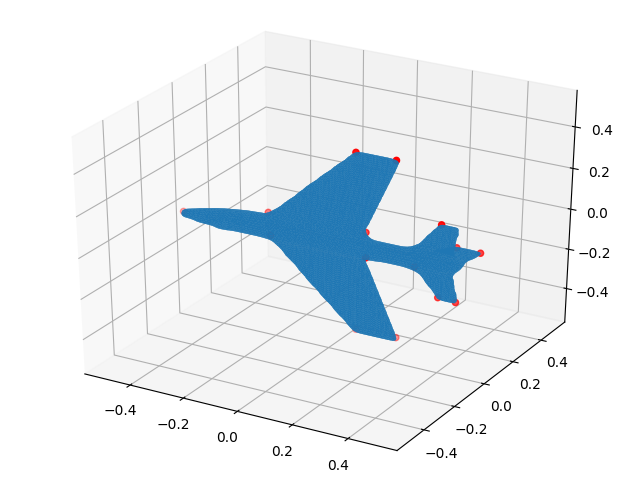

In [4]:
points = models["airplane_4"]['V'][(groundTruth["A"]["airplane_4"][2][10][0]-1).flatten()]
util.plotMesh(meshs["airplane_4"],points)

For first data set we only want to take into acount cluster that have more than 12 users in them and for the second data set we want clusters that have more than 9 users in them

In [5]:
params = {"A":(0,10), "B":(0,7)} # first item is sigma (start radius of each cluster 0:0.01) and second is n (number of users in each cluster)
processedGT = {}
for experiment in groundTruth.keys():
    temp = {name:[(groundT[i][j][0]-1).flatten(-1) for i in range(params[experiment][0],len(groundT)) for j in range(params[experiment][1],len(groundT[i]))] for name,groundT in groundTruth[experiment].items()}
    processedGT[experiment] = {name:np.array(list(set([item for sublist in groundT for item in sublist]))) for name,groundT in temp.items()}
# all_keys = list(set(functools.reduce(lambda x,y:list(x.keys())+list(y.keys()), groundTruth.values())))
# gt = dict.fromkeys(all_keys)

/Users/emehr/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  after removing the cwd from sys.path.


let's look out the selected points for one of the meshes:

<IPython.core.display.Javascript object>


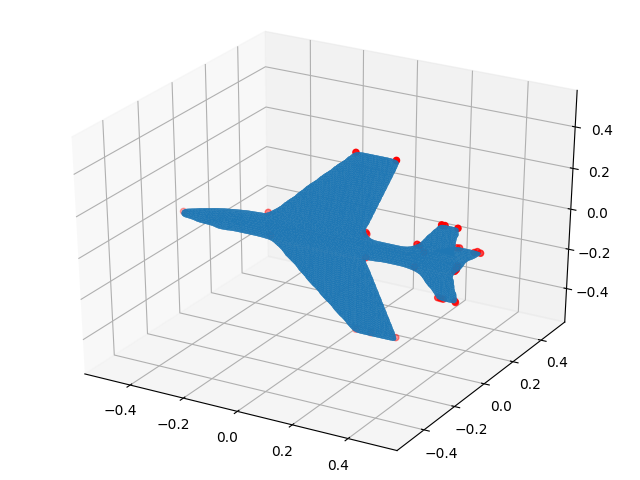

In [10]:
points = models["airplane_4"]['V'][processedGT["A"]["airplane_4"]]
util.plotMesh(meshs["airplane_4"],points)

Now we are going to engineer features that we will use to train our model.

Inputs to our model are local and global features for each vertex in a mesh. And the output is if that vertex a keypoint or not.

We also take into account different scales for each mesh to generate inputs. Meaning we will use a Gaussian filter with different radius to smooth out the mesh. And for each vertex in each smoothed mesh, we will calculate four features. 3 local features and 1 global feature.
1. Max, min, max-min, Mean, variance and harmonic mean of distances of the tangent plane at each vertex from neighboring vertices for each neighborhood ring of distance 1,2,3,4,5
2. Max, min, max-min, mean, variance and harmonic mean of angles between normal of each vertex and normal of neighboring vertices for each neighborhood ring of distance 1,2,3,4,5
3. Principal curvatures at the vertex, their mean and Gaussian curvature
4. Max, min, max-min, mean, variance and harmonic mean of values from reconstructed laplacian matrix of the mesh using smoothed eigenvalues

We choose 70% from each data set for training and 30% for test